This is a image classification using the transfer learning 


**Transfer learning**: it is a machine learning method where we reuse a pre-trained model as the starting point for a model on a new 



A pre-trained model is usually trained on a huge dataset such as ImageNet and the weights obtained from the trained model can be used for any other related application with your custom neural network. These newly built models can directly be used for predictions on relatively new tasks or can be used in training processes for related applications. This approach not only reduces the training time but also lowers the generalization error.   




there are four types of common and popular models 


Inception

VGG family

ResNet 

Xception




we are using the inception to examine how it works for the 3 classes of images we are using the inceptionV3 which is again the part of the inception 




**Introduction to Inception models**



The Inception V3 is a deep learning model based on Convolutional Neural Networks, which is used for image classification. The inception V3 is a superior version of the basic model Inception V1 which was introduced as GoogLeNet in 2014. As the name suggests it was developed by a team at Google.






**Inception V3 Model Architecture**



The inception v3 model was released in the year 2015, it has a total of 42 layers and a lower error rate than its predecessors. Let's look at what are the different optimizations that make the inception V3 model better.

The major modifications done on the Inception V3 model are

1)Factorization into Smaller Convolutions
2)Spatial Factorization into Asymmetric Convolutions
3)Utility of Auxiliary Classifiers
4)Efficient Grid Size Reduction


we enter into our code 

as we are required the libraries which are important for the execution 

we import the numpy and the pandas we also required with the tenserflow for all the model building and the execution 


In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [11]:
import tensorflow as tf

we are unzipping the folder here 

In [12]:
#!unzip -q /content/pizza_steak_sushi.zip

getting the training folder 

In [13]:
base_dir = "/content/train"

getting the validation folder 

In [14]:
base_dir1 = "/content/validation"

getting the test folder 

In [15]:
test_path = "/content/test_p_s_s"

Here we are preprocessing the image and we are using the 80 % of images for the training and the 20% images for the validation 


we are also doing the data augumantation by doing the random flips 

we can also see we are doing the resacling the images 




In [16]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,rotation_range = 40,width_shift_range = 0.2,height_shift_range = 0.2,shear_range = 0.2,
    zoom_range = 0.2,horizontal_flip = True,fill_mode = "nearest" ,validation_split = 0.2
)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(base_dir,target_size = (300,300),class_mode = "categorical",
                                                                  batch_size = 4,subset = "training",seed = 42)
validation_generator = validation_datagen.flow_from_directory(base_dir1,target_size = (300,300),class_mode = "categorical",
                                                         batch_size =4,subset = "validation",seed = 42)

Found 201 images belonging to 3 classes.
Found 14 images belonging to 3 classes.


Now we are importing the model of inceptionV3 by specifying the image size and specifying the requirements 

here we are importing the layers which are useful to us and we are not tarining the output layers 
so we are making the layers.trainable is false 



In [17]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (300,300,3),include_top = False,weights = "imagenet")
"""Freeze all layers to stop updating InceptionV3 trained weights."""
for layer in base_model.layers:
    layer.trainable = False

87924736/87910968 [==============================] - 0s 0us/step


Here we are seeing our last layer where the our image can last filter upto the dimensions of (8,8) and the 1280 are the params at the time 


simply our model can be able to filter  our image to this last layer 


In [18]:
"""You can change it if you want."""
last_layer = base_model.get_layer("mixed8")
print(last_layer.output_shape)

(None, 8, 8, 1280)


Here we are specifying the total images and the classes 

In [19]:
import os 
classes = os.listdir(base_dir)
for i in range(len(classes)):
    path = os.path.join(base_dir,classes[i])
    print(f"{classes[i]} has {len(os.listdir(path))} images")

sushi has 72 images
steak has 75 images
pizza_train has 103 images


Since our model is can able to do the image processing upto ( 8,8) so we need to add the last output layers 

so that the our layers able to dimnish completely 
to form the output layer 

In [20]:
"""Flatten layer to reduce output shape to 1dim."""
x = tf.keras.layers.Flatten()(last_layer.output)
"""Add fully connected layers with 256 units."""
x = tf.keras.layers.Dense(256,activation = "relu")(x)
"""Add Dropout layer."""
x = tf.keras.layers.Dropout(0.2)(x)
"""Output layer."""
x = tf.keras.layers.Dense(len(classes),activation = "softmax")(x)
"""Here we can connect our model end to end."""
model = tf.keras.models.Model(base_model.input,x)

Now  we have to see the total model summary 


we are import a part of the summary by importing the model and we are adding the some layers to model 

so we have to see our model completely executed 

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

The above is total sumary of the model now we have to make our own callbacks 


we know that the callbacks can also  imported an we can also write our own call backs so 
we writing our own call backs with the specific requirements  

In [22]:
model.compile(tf.keras.optimizers.RMSprop(learning_rate = 0.005),loss = "categorical_crossentropy",metrics = ["acc"])
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs = {}):
        if logs.get("acc") > 0.99:
            print("Accuracy reached %99.Stop training.")
            self.model.stop_training = True 

callback = myCallback()

Here we are running the epochs to train our model we are using the 30 epochs 

In [23]:
history = model.fit(train_generator,epochs = 30,batch_size = 4,validation_data = validation_generator,verbose = 1,
                   callbacks = [callback])

Epoch 1/30
51/51 [==============================] - 59s 1s/step - loss: 61.0984 - acc: 0.5174 - val_loss: 24.5091 - val_acc: 0.5000
Epoch 2/30
51/51 [==============================] - 55s 1s/step - loss: 5.3602 - acc: 0.7264 - val_loss: 5.7936e-04 - val_acc: 1.0000
Epoch 3/30
51/51 [==============================] - 53s 1s/step - loss: 2.7352 - acc: 0.7711 - val_loss: 0.0349 - val_acc: 1.0000
Epoch 4/30
51/51 [==============================] - 54s 1s/step - loss: 3.1570 - acc: 0.7264 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 5/30
51/51 [==============================] - 52s 1s/step - loss: 2.0979 - acc: 0.7662 - val_loss: 0.0213 - val_acc: 1.0000
Epoch 6/30
51/51 [==============================] - 53s 1s/step - loss: 1.3114 - acc: 0.8209 - val_loss: 3.0107e-05 - val_acc: 1.0000
Epoch 7/30
51/51 [==============================] - 52s 1s/step - loss: 1.1404 - acc: 0.8109 - val_loss: 0.3581 - val_acc: 0.9286
Epoch 8/30
51/51 [==============================] - 53s 1s/step - loss: 0.8784 -

This is the graph of the showing the accuracy 

we use the matplot library to draw the graphs and the graph 

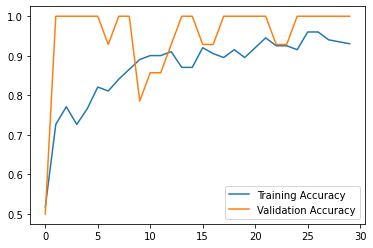

In [24]:
import matplotlib.pyplot as plt
"""Plot accuracy"""
acc = history.history["acc"]
val_acc = history.history["val_acc"]
epochs = range(30)
plt.plot(epochs,acc,label = "Training Accuracy")
plt.plot(epochs,val_acc,label = "Validation Accuracy")
plt.legend()
plt.show()

This is the graph of the showing the validation loss 

we use the matplot library to draw the graphs and the graph 

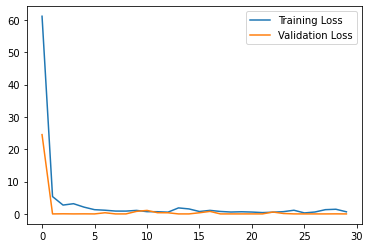

In [25]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(30)
plt.plot(epochs,loss,label = "Training Loss")
plt.plot(epochs,val_loss,label = "Validation Loss")
plt.legend()
plt.show()

our model is prepared and we are saving the model 


In [26]:
model.save("pizza_steak_sushitfl.h5")
model1 = tf.keras.models.load_model("pizza_steak_sushitfl.h5")

We are writting a snip of code to process the unknown image which is imported using the link 

here we can see we are specifying the dimensions and we are rescaling the url image by using the appropriate libraries 



In [27]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np

def get_and_process(url):
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img1 = img
        """Resize image for appropriate shape for model."""
        img = img.resize((300,300))
        """Convert img to numpy array,rescale it ,expand dims for model convenience. then check vertically."""
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = x / 255.0
        x = np.expand_dims(x,axis = 0)
        img_tensor = np.vstack([x])
        return img1,img_tensor

here we are prdicting the image by the url image which is getting from the browser 


Prediction is : steak


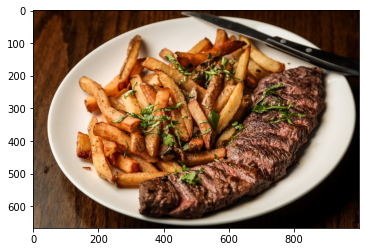

In [31]:
import matplotlib.pyplot as plt
url = "https://images.unsplash.com/photo-1600891964092-4316c288032e?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8Mnx8c3RlYWt8ZW58MHx8MHx8&w=1000&q=80"
img1,test_img = get_and_process(url)
pred = model1.predict(test_img)
classes = list(train_generator.class_indices.keys())
print(f"Prediction is : {classes[np.argmax(pred)]}")
plt.imshow(img1)
plt.show()

Here we are testing the model on our test folder image we are just dragging the image path and testing the image 

Prediction is : pizza_train


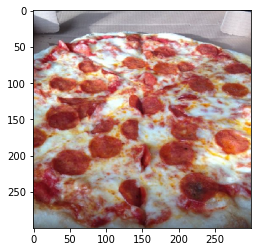

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
#url = "https://images.unsplash.com/photo-1600891964092-4316c288032e?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8Mnx8c3RlYWt8ZW58MHx8MHx8&w=1000&q=80"
#img1 = get_and_process(url)
img1 = keras.preprocessing.image.load_img(
    "/content/test_p_s_s/2111981.jpg", target_size=(300,300)
)
test_img = keras.preprocessing.image.img_to_array(img1)
test_img = tf.expand_dims(test_img, 0)
pred = model1.predict(test_img)
classes = list(train_generator.class_indices.keys())
print(f"Prediction is : {classes[np.argmax(pred)]}")
plt.imshow(img1)
plt.show()

We can see that the inception V3 model has an extremely low error rate compared with its previous models and its contemporaries.